# MNIST Dataset - "Hello World" ML

### **Exercise : Try to build a classifier that achieved over 97% on the well known MNIST Dataset**

From A. Guéron, "Hands-On Machine Learning with Scikit-Learn & TensorFlow", O'Reilly, 2017.
<br>
Chapter 3 - Classification. Notebook of the author available 
[here](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)

### *Short context* 

The MNIST Dataset is composed of 70 000 black and white images of single digits hand-written by the US Census Bureau and high school students. All the 70 000 images have been normalized to fit into 28*28 pixel bouding box and anti-aliased.
<br>
The MNIST dataset is composed of 60 000 images for the training set and 10 000 images for the test set. Each image is stored as a flattened array containing the intensity of every 784 pixels, ranging from 0 (white) to 255 (black). 
<br>
For more info, [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)

#### *Key skills* : Image processing, Hello World computer vision, Multinomial classification, Kernel SVM

### **Set up**

#### **Importing librairies**

In [1]:
import sys
import os

import numpy as np
import scipy as sp
from scipy.ndimage.interpolation import shift
from scipy.ndimage.measurements import center_of_mass
from scipy.stats import expon, reciprocal
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.datasets import fetch_mldata
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib

import warnings
from sklearn.exceptions import DataConversionWarning


In [2]:
print("Python interpreter : ", sys.version)
print("Numpy version : ", np.__version__)
print("Scipy version : ", sp.__version__)
print("Matplotlib version : ", matplotlib.__version__)
print("Scikit learn version : ", sklearn.__version__)

Python interpreter :  3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
Numpy version :  1.15.4
Scipy version :  1.1.0
Matplotlib version :  3.0.2
Scikit learn version :  0.20.1


In [3]:
warnings.simplefilter(action='ignore', category=(FutureWarning, DataConversionWarning))
np.set_printoptions(threshold=np.NaN)  #no limit to display full array
np.set_printoptions(suppress=True) #remove scientific notation
plt.style.use('default')
MODEL_SAVING_PATH = "./Models"

#### **Data import & preparation**

In [4]:
mnist = fetch_mldata('MNIST original')
X,y = mnist['data'], mnist['target']

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
np.random.seed(42)
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


### **Ultra quick EDA**

In [ ]:
print("X_train shape : {}, y_train shape : {}".format(X_train.shape, y_train.shape))

X_train shape : (60000, 784), y_train shape : (60000,)


A quick check for missing values or outliers

In [ ]:
print("Missing value in X_train and y_train : ({}, {})".format(np.isnan(X_train).sum(), 
                                                               np.isnan(y_train).sum()))
print("Min - Max values for pixel intensity {} - {}".format(X_train.min(), X_train.max()))

Missing value in X_train and y_train : (0, 0)
Min - Max values for pixel intensity 0 - 255


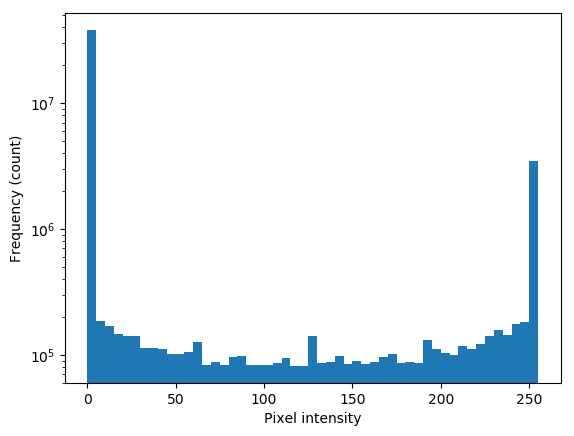

In [ ]:
plt.hist(X_train.flatten(), bins=range(0, 260, 5), log=True)
plt.xlabel('Pixel intensity')
plt.ylabel('Frequency (count)')
plt.show()

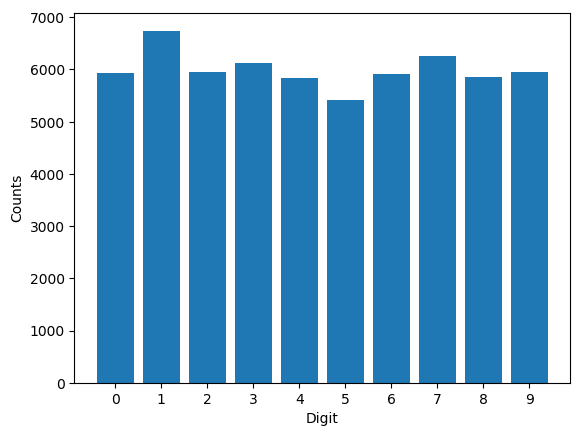

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(x= unique, height=counts, tick_label=range(10))
plt.xlabel('Digit')
plt.ylabel('Counts')
plt.show()

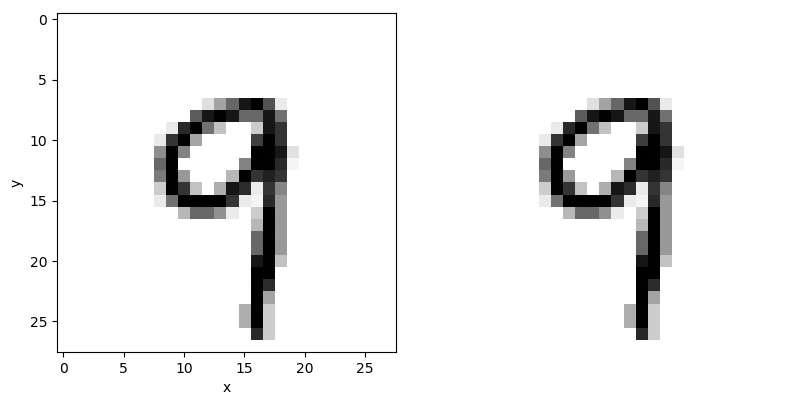

In [ ]:
some_digit = X_train[42]
some_digit_image = some_digit.reshape(28, 28)
fig, ax_arr = plt.subplots(1, 2, figsize=(8, 8))
ax_arr[0].imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
ax_arr[0].set(xlabel="x", ylabel='y')
ax_arr[1].imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
ax_arr[1].axis('off')
plt.tight_layout()
plt.show()

Overview of random digits, function code below from A. Guéron Notebook

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

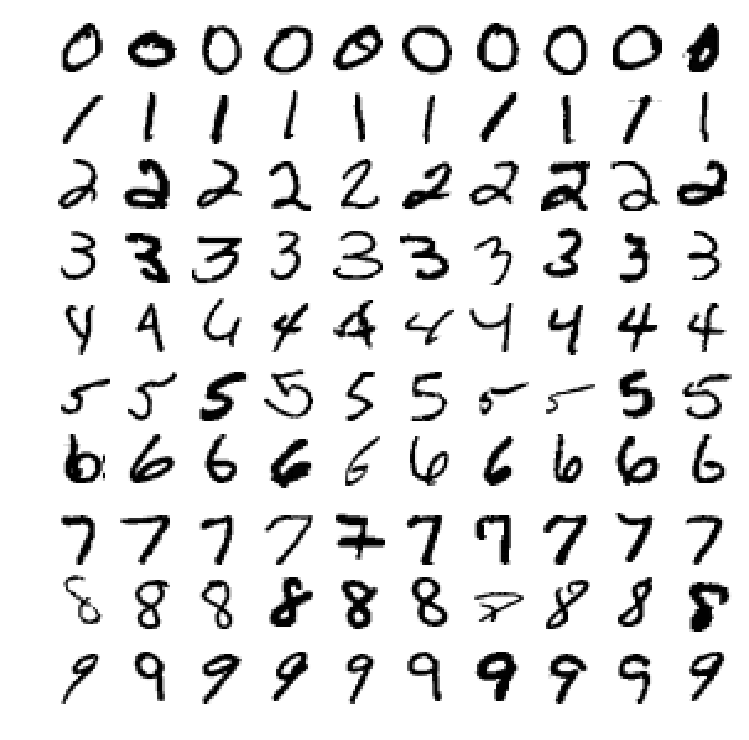

In [ ]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

### **Machine learning**

#### **Short-list promising models**

In [ ]:
model_d1 = {
    'knn': KNeighborsClassifier(),
    'logit': LogisticRegression(),
    'rFor': RandomForestClassifier(),
}
for key, clf in model_d1.items():
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()), #not needed for Random Forest
        ('clf', clf)
    ])
    cv = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
    print("Accuracy for 3Fcv with {} : mean : {:.1f}%, Std : {:.2f}%".format(key, 100 * cv.mean(), 100 * np.std(cv)))

model_d2 = {
    'lin_svm': LinearSVC(loss='hinge', dual=True), #prim not supported by Linear_SVC with hinge loss and l2 reg
    'rbf_svm': SVC(),
    'sgd_svm': SGDClassifier()
}
for key, clf in model_d2.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', clf)
    ])
    cv = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
    print("Accuracy for 3Fcv with {} : mean : {:.1f}%, Std : {:.2f}%".format(key, 100 * cv.mean(), 100 * np.std(cv)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


I applied different scalings according to models. My first guess was to go for a simple Min-Max scaling between 0-1 (commonly used for image processsing + several features including many 0s for all the instances). 
However, Linear_SVC performs regularization on intercept and hence data need to be center around 0 prior to training. Moreovere, sklearn documentation also specifies that : "Standardization of a dataset is a common requirement for many machine learning estimators [...]. For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizersof linear models) assume that all features are centered around 0 and have variance in the same order."

I tried both scaling for all the classifiers and I finally chose the scaler giving the best accuracy for each model (i.e. standardization for svm models and min-max scaling for the others). 

Here, K-N Neighbors, Support Vector Machine and Random Forest are the most promising models for the digits classification.
<br>
Considering the computation time to train the model, I will only focus my efforts on non-linear SVM classifier for the upcoming steps dedicated to fine-tuning. You will find a fully described solution for KNN in the notebook of the author. Without any pre-processing steps, KNN reached an accuracy of 97.1 % after hyperparameter tuning.

#### **Focus on SVM - Fine tuning the model**

**Pre-processing step : centering image**

In [ ]:
def NonZeroIndices(array, axis):
    """ Returns first and last non zeros indices in an array according to axis (0, 1) / for positive values only """
    bool_array = np.any((array != 0), axis=axis)
    c0 = np.argmax(bool_array)
    c1 = bool_array.shape[0] - np.argmax(bool_array[-1::-1]) - 1 #python starts from 0...
    return c0, c1

In [ ]:
def CenterImage(array, strategy='center_of_mass'):
    """ Return a centered array from a greyscale image, using 'center_of_mass' or 'personal' strategy"""
    if strategy == 'center_of_mass':
        x_array_m, y_array_m = np.median(range(array.shape[0])), np.median(range(array.shape[1]))
        x_m, y_m = center_of_mass(array)
        dx, dy = (round(x_array_m - x_m), round(y_array_m - y_m)) #add some "noise" if d is not an integer
    if strategy == 'personal':
        x_top, x_bottom = (min(NonZeroIndices(array, axis=1)), array.shape[0] - 1 - max(NonZeroIndices(array, axis=1)))
        y_left, y_right = (min(NonZeroIndices(array, axis=0)), array.shape[1] - 1 - max(NonZeroIndices(array, axis=0)))
        dx, dy = (round((x_bottom - x_top)/2), round((y_right - y_left)/2)) 
    return shift(array, [dx, dy], cval=0)

In [ ]:
class ImageCenter(BaseEstimator, TransformerMixin):
    def __init__(self, shaped_size=(28, 28), center_strategy='center_of_mass'):
        self.shaped_size = shaped_size
        self.x_shaped_size = self.shaped_size[0]
        self.y_shaped_size = self.shaped_size[1]
        self.center_strategy = center_strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_center_l = [] 
        for i in range(X.shape[0]):
            shaped_array = X[i].reshape(self.x_shaped_size, self.y_shaped_size)
            shaped_array_centered = CenterImage(shaped_array, strategy=self.center_strategy)
            X_center_l.append(shaped_array_centered.ravel())
        return np.r_[X_center_l]

In [ ]:
sub_sample = 100
some_digit = 21
X_center_mass = ImageCenter(center_strategy='center_of_mass').fit_transform(X_train[:sub_sample])
X_center_pers = ImageCenter(center_strategy='personal').fit_transform(X_train[:sub_sample])

fig, ax_arr = plt.subplots(1, 3, figsize=(9, 9))
ax_arr[0].imshow(X_train[some_digit].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
ax_arr[0].set(title='Original')
ax_arr[1].imshow(X_center_mass[some_digit].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
ax_arr[1].set(title='Centered (center of mass)')
ax_arr[2].imshow(X_center_pers[some_digit].reshape(28, 28), cmap=matplotlib.cm.binary, interpolation="nearest")
ax_arr[2].set(title='Centered (personal)')
plt.tight_layout()
plt.show()

In [ ]:
pipeline = Pipeline([
    ('center', ImageCenter()),
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
param_grid = [{'center__center_strategy': ['center_of_mass', 'personal']}]
cv = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
cv.fit(X_train, y_train)
print('Best score : {:.1f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))

**Hyperparameter tuning with RandomizedSearch CV**

In [ ]:
sub_size = 20000
X_train_sub, y_train_sub = X_train[:sub_size], y_train[:sub_size]
X_train_sub_center = ImageCenter(center_strategy="personal").fit_transform(X_train_sub)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
param_grid = {
    'svm__kernel': ['rbf'], 
    'svm__C': reciprocal(0.05, 500), 'svm__gamma': expon(scale=0.01)}

cv = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, scoring='accuracy', cv=3, random_state=42, verbose=2, n_jobs=-1)

cv.fit(X_train_sub_center, y_train_sub)

In [ ]:
print('Best score : {:.1f}%, best parameters : {}'.format(cv.best_score_ * 100, cv.best_params_))


In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(cv.cv_results_['param_svm__C'], cv.cv_results_['param_svm__gamma'])
ax.scatter(cv.best_params_['svm__C'], cv.best_params_['svm__gamma'], c='r', label='Best params')
ax.set(xscale='log', yscale='log', 
       xlim=[0.05, 500], ylim=[np.min(cv.cv_results_['param_svm__gamma'])*(1-0.1), np.max(cv.cv_results_['param_svm__gamma'])*(1+0.1)], 
       xlabel='C', ylabel='gamma')
ax.legend()
plt.tight_layout()
plt.show()

With more computational power and time, it would be interesting to run again a randomized search between 10 and 1000 for C on the full training set. Other kernel for SVM should also be explored (e.g. polynomial, sigmoid). For the current exercise, this small feature space exploration should grant the 97% accuracy objective for the classifier.

In [ ]:
best_par = cv.best_params_
pipeline = Pipeline([
    ('center', ImageCenter(center_strategy='personal')),
    ('scaler', StandardScaler()),
    ('svm', SVC(C=best_par['svm__C'], gamma=best_par['svm__gamma']))
])
clf_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

In [ ]:
print("Accuracy for 3Fcv with SVM(rbf) : mean : {:.1f}%, Std : {:.2f}%".format(100 * clf_scores.mean(), 100 * np.std(clf_scores)))

In [ ]:
svm_clf = pipeline.fit(X_train, y_train)
os.makedirs(MODEL_SAVING_PATH, exist_ok=True)
joblib.dump(svm_clf, os.path.join(MODEL_SAVING_PATH, 'svm_clf.pkl'))

#### **Performance on the test set**

In [ ]:
y_pred = svm_clf.predict(X_test)
print('Accuracy on the test set : {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

### **Going further ...**

**Matrix of confusion**

In [ ]:
y_val_pred = cross_val_predict(pipeline, X_train, y_train, cv=3, verbose=2, n_jobs=-1)
conf_mat = confusion_matrix(y_train, y_val_pred)
print(conf_mat)

In [ ]:
conf_mat_rel = conf_mat/conf_mat.sum(axis=1, keepdims=True)
conf_mat_rel[np.diag_indices_from(conf_mat)] = 0
plt.figure(figsize=(8, 8))
plt.imshow(conf_mat_rel, cmap=matplotlib.cm.binary)
plt.xlabel("Predicted values")
plt.xticks(ticks=range(10), labels=range(10))
plt.ylabel("Actual values")
plt.yticks(ticks=range(10), labels=range(10))
plt.colorbar()
plt.show()

In [ ]:
cl_a, cl_b = 4, 9
X_aa = X_train[(y_train == cl_a) & (y_val_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_val_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_val_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_val_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.title('Well classified 4')
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.title('4 missclassified as 9')
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.title('9 missclassified as 4')
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.title('Well classified 9')
plt.show()

#### **Data augmentation**

In [ ]:
def Shift_image(flat_array, dx=0, dy=0, im_shape=(28, 28)):
    shift_array_l = []
    for i in range(flat_array.shape[0]):
        im_shaped = flat_array[i].reshape(im_shape)
        shift_array = shift(im_shaped, [dx, dy], cval=0)
        shift_array_l.append(shift_array.ravel())
    return np.r_[shift_array_l]

In [ ]:
X_train_c = ImageCenter(center_strategy='personal').fit_transform(X_train)

idx_mask = (y_train == 4) | (y_train == 9) | (y_train == 3) | (y_train == 5)
X_train_c_up = Shift_image(X_train_c[idx_mask], dx=-1)
X_train_c_down = Shift_image(X_train_c[idx_mask], dx=1)
X_train_c_left = Shift_image(X_train_c[idx_mask], dy=-1)
X_train_c_right = Shift_image(X_train_c[idx_mask], dy=1)


In [ ]:
some_digit = 42
some_digit_image = X_train_c[idx_mask][some_digit].reshape(28, 28)
some_digit_image_up = X_train_c_up[some_digit].reshape(28, 28)
some_digit_image_down = X_train_c_down[some_digit].reshape(28, 28)
some_digit_image_left = X_train_c_left[some_digit].reshape(28, 28)
some_digit_image_right = X_train_c_right[some_digit].reshape(28, 28)
fig, ax_arr = plt.subplots(2, 3, figsize=(9, 6))
ax_arr[0, 0].imshow(some_digit_image_left, cmap=matplotlib.cm.binary, interpolation='nearest')
ax_arr[0, 1].imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
ax_arr[0, 2].imshow(some_digit_image_right, cmap=matplotlib.cm.binary, interpolation='nearest')
ax_arr[1, 0].imshow(some_digit_image_down, cmap=matplotlib.cm.binary, interpolation='nearest')
ax_arr[1, 1].imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
ax_arr[1, 2].imshow(some_digit_image_up, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.tight_layout()
plt.show()

In [ ]:
X_train_shift = np.r_[X_train_c, X_train_c_up, X_train_c_down, X_train_c_left, X_train_c_right]
y_train_shift = np.r_[y_train, np.tile(y_train[idx_mask], (4,))]
print(X_train_shift.shape, y_train_shift.shape)

In [ ]:
shuffle_index = np.random.permutation(X_train_shift.shape[0])
X_train_shift, y_train_shift = X_train_shift[shuffle_index], y_train_shift[shuffle_index]

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=best_par['svm__C'], gamma=best_par['svm__gamma']))
    ])
pipeline.fit(X_train_shift, y_train_shift)


In [ ]:
y_pred = pipeline.predict(ImageCenter(center_strategy='personal').transform(X_test))
print('Accuracy on the test set : {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Still better than nothing but I was hoping a higher increase of the accuracy with data augmentation. A slightly better score might still be observed with data augmentatation on the full dataset ...

In [ ]:
joblib.dump(pipeline, os.path.join(MODEL_SAVING_PATH, 'final_svm_clf.pkl'))

### **Coming next...**

I Should definitely try to perform dimension reduction (e.g. PCA, custom croping) prior to classification considering the many "useless" features full of 0s (white pixels close to borders). It should significantly speed up training without losing much information.   